# Introduction

In this project we want to create a model that can predict the price of a diamond based on its characteristics. 

For this we are going to perform three different procedures. 
On the one hand a linear model, specifically a linear regression model. As a second model we will use an emsabled model such as RandomForest, tuning the hyperparameters with a Bayesian optimization model such as HyperOpt. And finally, we will test the Pycaret library, where we will choose the most appropriate model.

# Data

The Diamonds DataSet has been obtained from Kaggle, at the following [link](https://www.kaggle.com/shivam2503/diamonds). In it, each input is a diamond and the columns correspond to diamond characteristics.

**Predictors Variables** 

 `id`: Input ID.
 
 `carat`: diamond weight.
 
 `cut`: The way in which the diamond facets interact with light.
 
 `clarity`: Purity or transparency of a diamond.
 
 `color`: Color of a diamond.
 
 `table`: Flat part of the upper part.
 
 `x`: Length in mm.

 `y`: Width in mm.

 `z`: Depth in mm.

 `depht`:  Total depth percentage = z / mean(x, y) = 2 * z / (x + y).


**Target Variable**

`price`: Diamond price.

# Libraries

First of all, import the libraries we are going to use.

In [115]:
#import libraries

#data processing
#--------------------------------------------
import pandas as pd
import numpy as np

#graphics
#--------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
%matplotlib inline

#preprocessig
#--------------------------------------------
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split



#modelling
#--------------------------------------------
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold

#Hyperopt
#---------------------------------------------
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

#Pycaret
#---------------------------------------------
from pycaret.regression import *


#others
#----------------------------------------------
from src.utils import unzip_zip
import warnings
warnings.filterwarnings('ignore')

# Checking Data

## First Approach

Using the `unzip_zip` function contained in `utils.py` in the folder `src`, we unzip the `.csv` files and load them into a Dataframe.

We save the DataFrames in variables.

In [3]:
#unzip and read csv
df_train = unzip_zip("data/diamonds-datamad0121.zip", "train.csv")

Now, let's check the DataFrame

In [4]:
#check data
df_train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.50,Premium,F,VS2,61.5,58.0,7.32,7.34,4.51,9.588
1,1,2.01,Very Good,E,SI2,60.6,59.0,8.11,8.25,4.96,9.748
2,2,0.50,Ideal,E,SI1,61.6,57.0,5.13,5.09,3.15,7.255
3,3,0.25,Very Good,F,VVS2,61.6,57.0,4.05,4.08,2.50,6.450
4,4,0.52,Ideal,G,VS2,62.0,55.0,5.16,5.19,3.21,7.721


In [5]:
#check the number of columns and rows
df_train.shape

(40455, 11)

In [6]:
#check the columns
df_train.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z', 'price'],
      dtype='object')

In [7]:
#check types
df_train.dtypes

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

In [8]:
#check data
df_train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.50,Premium,F,VS2,61.5,58.0,7.32,7.34,4.51,9.588
1,1,2.01,Very Good,E,SI2,60.6,59.0,8.11,8.25,4.96,9.748
2,2,0.50,Ideal,E,SI1,61.6,57.0,5.13,5.09,3.15,7.255
3,3,0.25,Very Good,F,VVS2,61.6,57.0,4.05,4.08,2.50,6.450
4,4,0.52,Ideal,G,VS2,62.0,55.0,5.16,5.19,3.21,7.721


In [9]:
#check if there are any null value 
df_train.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

It seems that there aren't any null value in the features.

Let's check the target variable: `price`

## Target Variable

<AxesSubplot:xlabel='price', ylabel='Count'>

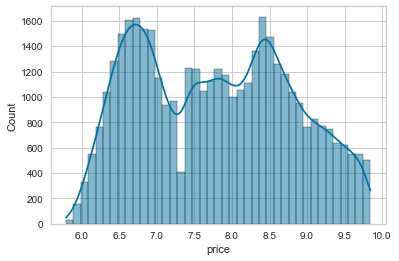

In [131]:
sns.histplot(data=df_train, x="price", kde=True)

## Numerical Predictors Variables

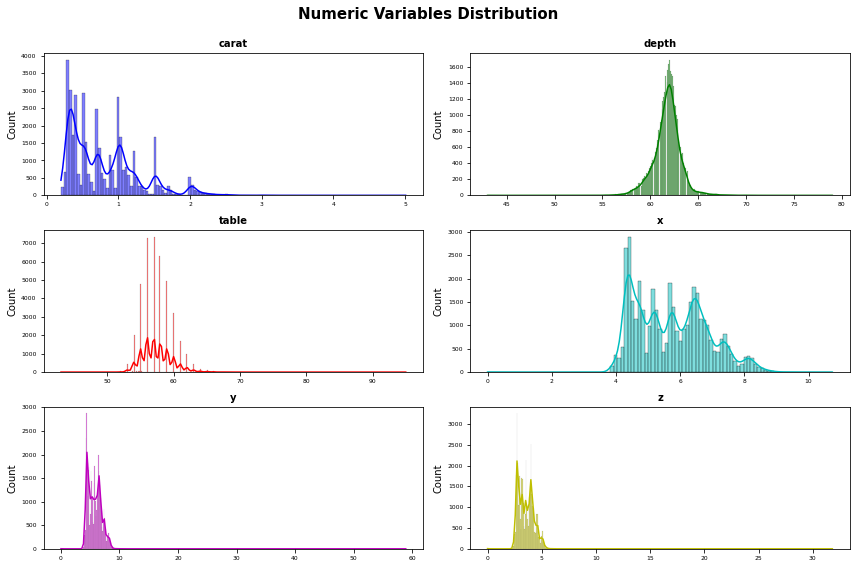

In [11]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(12, 8))
axes = axes.flat
numerical_cols = df_train.drop("price", axis=1).select_dtypes(include=["int", "float"]).columns

for ind, col in enumerate(numerical_cols):
    sns.histplot(data = df_train, x = col, color = list(mcolors.BASE_COLORS)[ind], kde=True, ax = axes[ind])
    
    axes[ind].set_title(col, fontsize = 10, fontweight = "bold")
    axes[ind].tick_params(labelsize = 6)
    axes[ind].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle("Numeric Variables Distribution", fontsize = 15, fontweight = "bold");

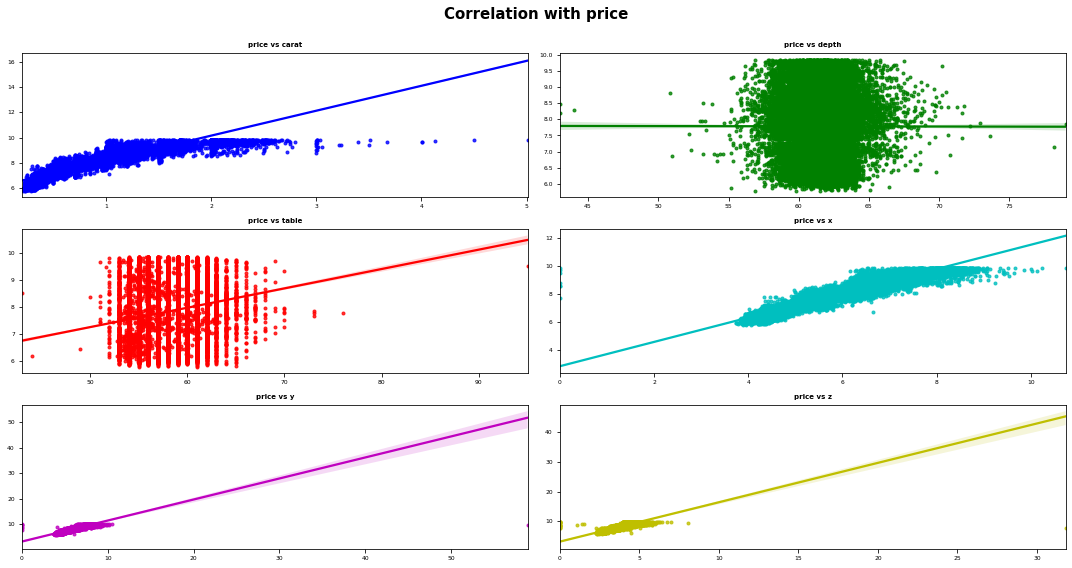

In [12]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(15,8))
axes = axes.flat
for ind, cols in enumerate(numerical_cols):
    sns.regplot(x = cols, y = "price", data = df_train, color = list(mcolors.BASE_COLORS)[ind], marker = ".", ax = axes[ind])
    
    axes[ind].set_title(f"price vs {cols}", fontsize = 7, fontweight = "bold")
    axes[ind].tick_params(labelsize = 6)
    axes[ind].set_xlabel("")
    axes[ind].set_ylabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Correlation with price", fontsize = 15, fontweight = "bold");

## Categorical Predictors Variables

Text(0.5, 0.98, 'Categorical Variables Distribution')

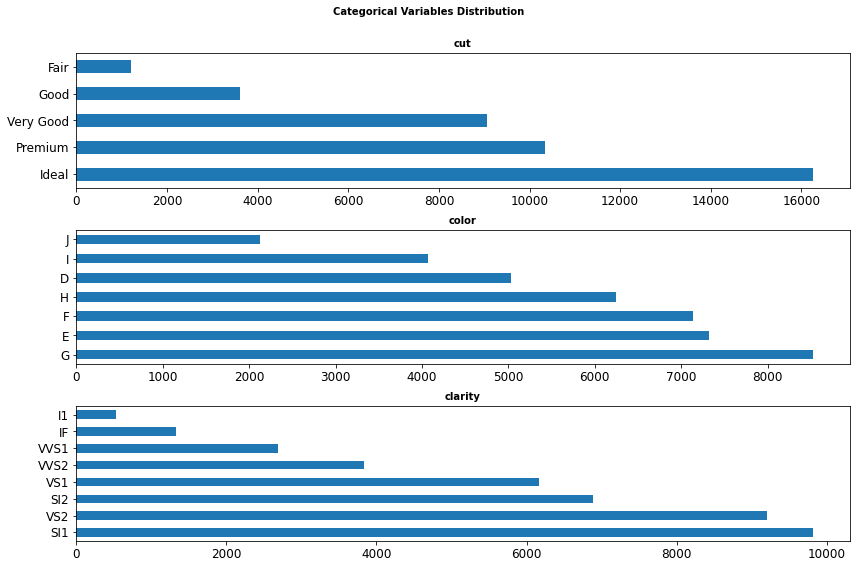

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8))
axes = axes.flat
categorical_cols = df_train.select_dtypes(include=["object"]).columns
for ind, cols in enumerate(categorical_cols):
    df_train[cols].value_counts().plot.barh(ax=axes[ind])
    axes[ind].set_title(cols, fontsize=10, fontweight="bold")
    axes[ind].tick_params(labelsize=12)
    axes[ind].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Categorical Variables Distribution", fontsize=10, fontweight="bold")

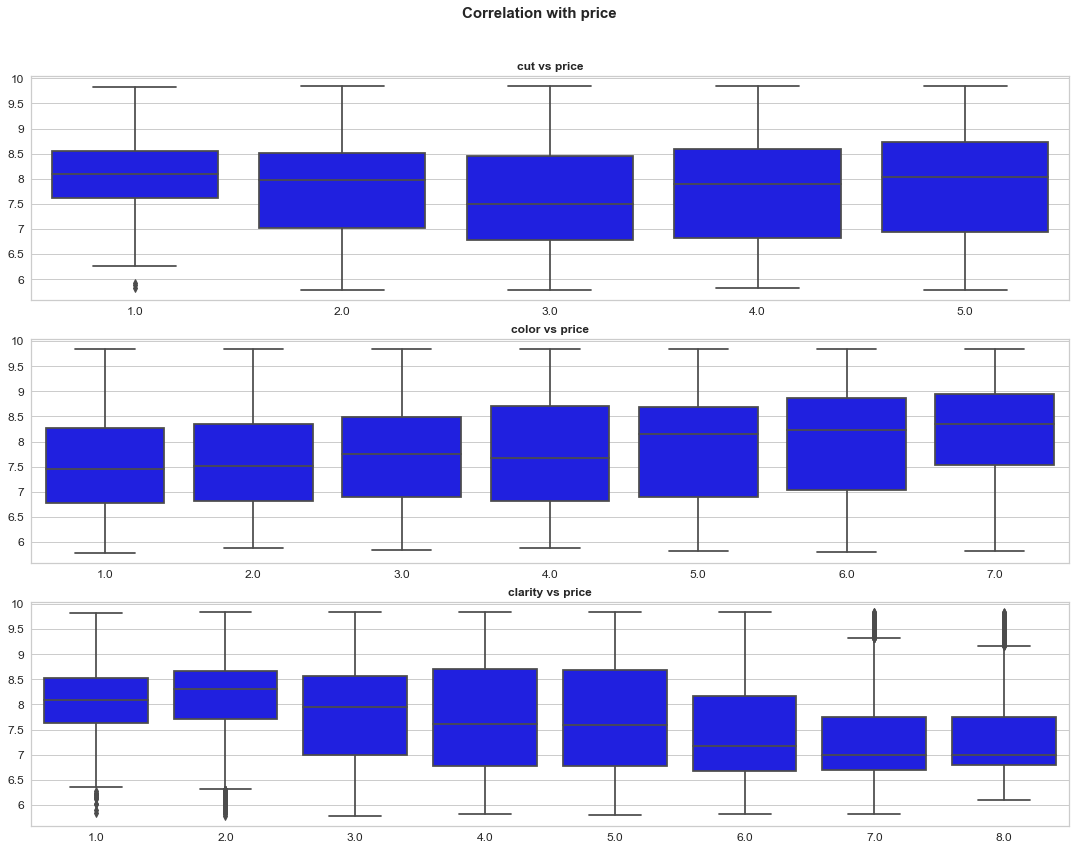

In [121]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(15,12))
axes = axes.flat
for ind, cols in enumerate(categorical_cols):
    sns.boxplot(x = cols, y="price", data=df_train, color="blue", ax=axes[ind])

    axes[ind].set_title(f"{cols} vs price", fontsize = 12, fontweight = "bold")
    axes[ind].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[ind].tick_params(labelsize = 12)
    axes[ind].set_xlabel("")
    axes[ind].set_ylabel("")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Correlation with price", fontsize = 15, fontweight = "bold");

# Preprocessing Data

## Dropping ID Variable

As a first action, we will delete the `id` column because it does not give us any relevant information about the diamonds.

In [15]:
#drop columns: id -> Useless
df_train = df_train.drop(["id"], axis=1)

## Encoding Categorical Variables

Now, let's check the values of the `object` type features.

In [16]:
#check uniques
df_train.clarity.unique()

array(['VS2', 'SI2', 'SI1', 'VVS2', 'VS1', 'VVS1', 'IF', 'I1'],
      dtype=object)

In [17]:
df_train.cut.unique()

array(['Premium', 'Very Good', 'Ideal', 'Good', 'Fair'], dtype=object)

In [18]:
df_train.color.unique()

array(['F', 'E', 'G', 'D', 'J', 'I', 'H'], dtype=object)

Going deeper into the diamond information, we have seen that the values of the three features (`clarity`, `cut`, and `color`) have a scale, that is, they follow an order.

Therefore, our strategy for converting these features to numerical is a hand encoding. By setting values from $1$ -> smallest value, to $n$ -> largest value.

We create dictionaries where the keys are the categorical value and the values are the numerical values that we assign to them.

In [19]:
#review diamond documentation and see that there 
#is numerical order in the categorical features. Encode the categorical features by numerical features.
encoding_cut =  {"Fair":1, "Good":2, 
          "Ideal":3, "Very Good":4, "Premium":5}
    
    
encoding_color = {'E':1,'D':2,'F':3,
             'G':4,'H':5,'I':6,
             'J':7}

encoding_clarity = {'I1':1,'SI2':2,
               'SI1':3,'VS2':4,'VS1':5,
               'VVS2':6,'VVS1':7,'IF':8}

Using the `.apply` method we apply a `lambda` function in which we change the categorical value by the numerical value to each column.

And store the numeric value in the DataFrame column to replace the values.

In [20]:
#replace categorical variables with numerical variables
df_train["cut"] = df_train["cut"].apply(lambda x: encoding_cut[x])
df_train["color"] = df_train["color"].apply(lambda x: encoding_color[x])
df_train["clarity"] = df_train["clarity"].apply(lambda x: encoding_clarity[x])

## Ols Regression

By means of `ols` we will check the influence of the variables on the target variable.

In [21]:
#Let's get the summary of the metrics.
#Set 'price' as target variable, and the rest as predictors variables. And, them, fit the model.
train_results = smf.ols(
    "price ~ carat + cut + color + clarity + depth + table + x+ y + z",
    data=df_train).fit()
#We see the summary
train_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 1.130e+05
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:25:54   Log-Likelihood:                 8045.6
No. Observations:               40455   AIC:                        -1.607e+04
Df Residuals:                   40445   BIC:                        -1.599e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5400      0.070    -21.989      0.000      -1.677      -1.403
carat         -0.6100      0.010    -63.207      0.000      -0.629      -0.591
cut            0.0074      0.001      7.469      0.000       0.005       0.009
color         -0.0721      0.001   -122.497      0.000      -0.073      -0.071
clarity        0.1173      0.001    177.315      0.000       0.116       0.119
depth          0.0428      0.001     50.631      0.000       0.041       0.044
table         -0.0006      0.000     -1.159      0.246      -0.002       0.000
x              1.1490      0.006    181.379      0.000       1.137       1.161
y              0.0402      0.004     10.552      0.000       0.033       0.048
z              0.0392      0.006      6.463      0.000       0.027       0.051
==============================================================================
Omnibus:                    75130.470   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        605187869.127
Skew:                          13.334   Prob(JB):                         0.00
Kurtosis:                     601.596   Cond. No.                     6.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see, the `R-squared` label has a value of `0.962`. `R-squared` is the percentage of variation of the target variable that explains its relationship with one or more predictor variables. This value is between $0$ and $1$, and the closer to $1$ the better the fit of the model to data.

In the $P>|t|$ tag of the `table` feature it exceeds $0.05$ so, therefore, this feature does not give us information regarding the target variable.

So, we proceed to drop the `table` feature.

In [22]:
#drop "table" column
df_train = df_train.drop("table", axis=1)

We check if `R-squared` has been changed.

In [23]:
#chek metrics
train_results = smf.ols(
    "price ~ carat + cut + color + clarity + depth + x + y + z",
    data=df_train).fit()
train_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 1.272e+05
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:25:57   Log-Likelihood:                 8044.9
No. Observations:               40455   AIC:                        -1.607e+04
Df Residuals:                   40446   BIC:                        -1.599e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5861      0.058    -27.530      0.000      -1.699      -1.473
carat         -0.6104      0.010    -63.311      0.000      -0.629      -0.592
cut            0.0072      0.001      7.378      0.000       0.005       0.009
color         -0.0721      0.001   -122.492      0.000      -0.073      -0.071
clarity        0.1174      0.001    178.839      0.000       0.116       0.119
depth          0.0431      0.001     52.397      0.000       0.041       0.045
x              1.1489      0.006    181.389      0.000       1.136       1.161
y              0.0404      0.004     10.593      0.000       0.033       0.048
z              0.0393      0.006      6.476      0.000       0.027       0.051
==============================================================================
Omnibus:                    75126.423   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        605125108.949
Skew:                          13.332   Prob(JB):                         0.00
Kurtosis:                     601.565   Cond. No.                     3.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that it has exactly the same value, so the deleted variable did not explain anything with respect to the target variable.

We save the cleaned DataFrame in a `.csv` file.

In [24]:
#convert to .csv
df_train.to_csv("input/train_clean.csv", header=True, index=False)

# Creating Models

## Linear Regression

To begin, we will perform a linear regression model as a means of predicting the price of diamonds based on the predictor variables we saw earlier.

In [25]:
#import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error as mse, make_scorer, r2_score as r2
from sklearn.linear_model import LinearRegression

We set the variable `X` for the predictor variables, and the variable `y` for the target variable.

In [26]:
#take predictors variables and response variable
X = df_train.drop("price", axis=1)
y = df_train["price"]

We use the `train_test_split` method to split the `X` and `y` into a 0.8 train and a 0.2 test.

We will train the model with the 0.8 selected by the method and test it with the 0.2 of the test.

In [27]:
#split the data 0.8 traon, 0.2 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=444)

We trained the linear regression model with the 0.8 train and made predictions.

In [28]:
#select the model and put it into a variable
lr = LinearRegression()

#train model
lr.fit(X_train, y_train)

#predict y
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

We compute de mean square error with `mean_square_error` method.

In [72]:
#compute mean square error
mse_train_lr = mse(y_train, y_pred_train_lr)
mse_test_lr = mse(y_test, y_pred_test_lr)

We check the mean square error of the and of the 0.2 of the test

In [30]:
#check mean square error
mse_test_lr

0.03440628945958964

In [31]:
#check various tests
cv = RepeatedKFold(n_splits=10, n_repeats=5)
score = make_scorer(mse)
cv_scores = cross_validate(estimator=LinearRegression(), X=X, y=y, scoring=(score), cv=cv, return_train_score = True)

df_scores = pd.DataFrame(cv_scores)
df_scores

,fit_time,score_time,test_score,train_score
0,0.017953,0.003989,0.043616,0.038866
1,0.016957,0.002994,0.026866,0.040749
2,0.016954,0.002992,0.041883,0.039058
3,0.012966,0.004988,0.048625,0.038320
4,0.014961,0.001994,0.027680,0.040662
5,0.010974,0.002989,0.055004,0.037668
6,0.009977,0.001992,0.078177,0.035598
7,0.010971,0.001994,0.026507,0.040784
8,0.009972,0.001993,0.367902,0.038522
9,0.014962,0.002990,0.027187,0.040708


<AxesSubplot:xlabel='test_score', ylabel='Count'>

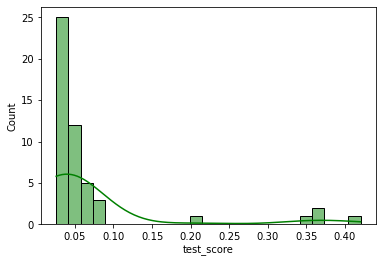

In [32]:
plt.plot(figsize=(12,8))
sns.histplot(data=df_scores["test_score"], kde=True, color="green")

In [34]:
final_df = pd.DataFrame({"Real":y_test, "Linear_Regression": y_pred_test_lr})
final_df.head()

,Real,Linear_Regression
13698,7.625,7.578904
4646,8.284,8.222004
24557,8.401,8.119892
17868,8.150,8.099549
12010,6.170,6.340317


## Random Forest Model with Hyperopt

In [35]:
params = {
        "n_estimators":hp.quniform("n_estimators", 10, 1000, 25),
        "max_depth":hp.quniform("max_depth", 4, 16, 1),
        "max_features":hp.quniform("max_features",2 ,8, 1),
        "min_samples_split":hp.quniform("min_samples_split", 2, 15, 1),
        "min_samples_leaf":hp.quniform("min_samples_leaf", 1,5,1)
}

In [36]:
def objetive(param):
    rf = RandomForestRegressor(n_estimators=int(param["n_estimators"]),
                      max_depth=int(param["max_depth"]),
                      max_features=int(param["max_features"]),
                      min_samples_split=int(param["min_samples_split"]),
                      min_samples_leaf=int(param["min_samples_leaf"]))
    
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    rmse = mse(y_test, y_pred)**(0.5)
    return {'loss':rmse, 'status': STATUS_OK }

In [37]:
trials_reg = Trials()
best = fmin(fn=objetive,
            space=params,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials_reg
            )

100%|██████████| 10/10 [04:51<00:00, 29.19s/trial, best loss: 0.09359632803692486]


In [38]:
best

{'max_depth': 15.0,
 'max_features': 5.0,
 'min_samples_leaf': 3.0,
 'min_samples_split': 6.0,
 'n_estimators': 425.0}

In [39]:
rf_model = RandomForestRegressor(
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    max_features=int(best["max_features"]),
    min_samples_split=int(best["min_samples_split"]),
    min_samples_leaf=int(best["min_samples_leaf"])
)

In [43]:
rf_model.fit(X_train, y_train)
y_pred_test_rf=rf_model.predict(X_test)
mse(y_test, y_pred)

0.008725535326591764

In [45]:
final_df["RFHyperopt"] = y_pred_test_rf
final_df.head()

,Real,Linear_Regression,RFHyperopt
13698,7.625,7.578904,7.725441
4646,8.284,8.222004,8.283101
24557,8.401,8.119892,8.338785
17868,8.150,8.099549,8.047047
12010,6.170,6.340317,6.315764


## Pycaret

In [46]:
df_train[["cut", "color", "clarity"]] = df_train[["cut", "color", "clarity"]].apply(lambda x:x.astype("float64"))

In [47]:
df_train.dtypes

carat      float64
cut        float64
color      float64
clarity    float64
depth      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

In [48]:
exp_clf101 = setup(data = df_train, target = "price", session_id=123)

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(40455, 9)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(28318, 8)"


In [49]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0665,0.0084,0.0918,0.9918,0.0105,0.0086,0.2470
et,Extra Trees Regressor,0.0684,0.0092,0.0958,0.9910,0.0110,0.0089,2.7490
rf,Random Forest Regressor,0.0677,0.0093,0.0963,0.9909,0.0110,0.0088,3.9620
gbr,Gradient Boosting Regressor,0.0829,0.0118,0.1085,0.9885,0.0127,0.0110,1.0300
dt,Decision Tree Regressor,0.0898,0.0171,0.1307,0.9833,0.0149,0.0116,0.0840
knn,K Neighbors Regressor,0.1067,0.0214,0.1463,0.9791,0.0171,0.0141,0.0980
ada,AdaBoost Regressor,0.1569,0.0391,0.1978,0.9619,0.0232,0.0207,0.7440
huber,Huber Regressor,0.1242,0.0720,0.2433,0.9301,0.0294,0.0161,0.3840
par,Passive Aggressive Regressor,0.1759,0.0873,0.2784,0.9155,0.0314,0.0231,0.0460
ridge,Ridge Regression,0.1292,0.0928,0.2546,0.9104,0.0294,0.0167,0.0180


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [50]:
lgbm_reg = create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0682,0.0089,0.0942,0.9914,0.0108,0.0088
1,0.0669,0.0083,0.0914,0.9917,0.0104,0.0086
2,0.0662,0.0080,0.0897,0.9922,0.0102,0.0085
3,0.0662,0.0080,0.0892,0.9924,0.0101,0.0086
4,0.0651,0.0081,0.0901,0.9922,0.0103,0.0084
5,0.0660,0.0081,0.0899,0.9921,0.0103,0.0086
6,0.0660,0.0084,0.0915,0.9919,0.0104,0.0086
7,0.0660,0.0078,0.0880,0.9926,0.0101,0.0086
8,0.0681,0.0102,0.1011,0.9896,0.0115,0.0088
9,0.0667,0.0086,0.0927,0.9915,0.0107,0.0087


In [51]:
tuned_lgbm = tune_model(lgbm_reg, search_library = "tune-sklearn", search_algorithm="hyperopt", n_iter=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0782,0.0113,0.1065,0.9890,0.0123,0.0103
1,0.0779,0.0105,0.1026,0.9896,0.0119,0.0102
2,0.0771,0.0102,0.1009,0.9901,0.0117,0.0101
3,0.0767,0.0101,0.1005,0.9903,0.0116,0.0101
4,0.0761,0.0103,0.1015,0.9901,0.0118,0.0100
5,0.0765,0.0102,0.1010,0.9900,0.0118,0.0101
6,0.0780,0.0106,0.1031,0.9897,0.0120,0.0103
7,0.0756,0.0095,0.0975,0.9909,0.0114,0.0100
8,0.0785,0.0129,0.1134,0.9870,0.0131,0.0104
9,0.0773,0.0106,0.1032,0.9895,0.0121,0.0102


In [52]:
tuned_opt_lgbm = tune_model(lgbm_reg, search_library = "tune-sklearn", search_algorithm="optuna", n_iter=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0805,0.0120,0.1097,0.9883,0.0127,0.0106
1,0.0801,0.0110,0.1050,0.9891,0.0122,0.0105
2,0.0795,0.0107,0.1032,0.9896,0.0120,0.0105
3,0.0782,0.0103,0.1015,0.9901,0.0118,0.0103
4,0.0786,0.0109,0.1045,0.9895,0.0122,0.0104
5,0.0793,0.0107,0.1035,0.9895,0.0122,0.0105
6,0.0805,0.0112,0.1059,0.9892,0.0123,0.0107
7,0.0779,0.0100,0.1000,0.9905,0.0118,0.0103
8,0.0804,0.0136,0.1166,0.9862,0.0135,0.0106
9,0.0802,0.0114,0.1066,0.9888,0.0125,0.0106


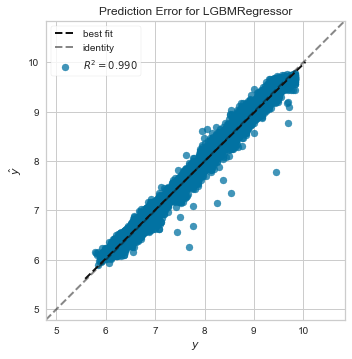

In [53]:
plot_model(tuned_lgbm, plot = "error")

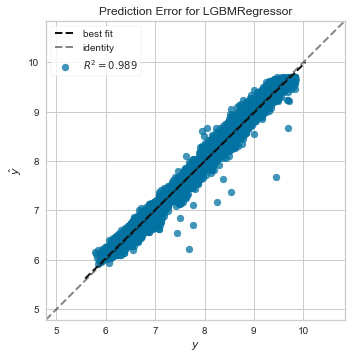

In [54]:
plot_model(tuned_opt_lgbm, plot = "error")

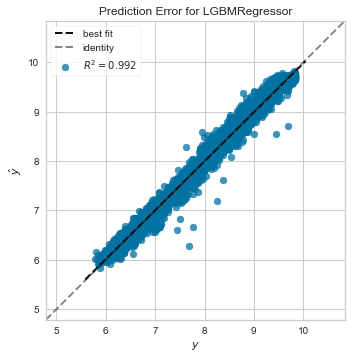

In [55]:
plot_model(lgbm_reg, plot = "error")

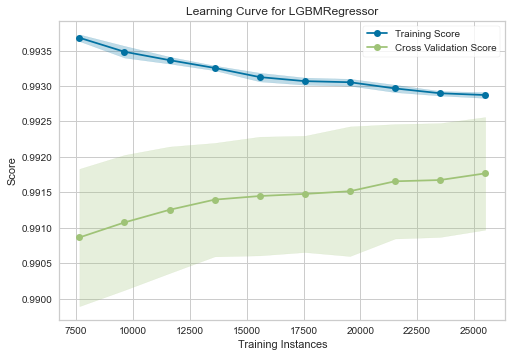

In [56]:
plot_model(lgbm_reg, plot = "learning")

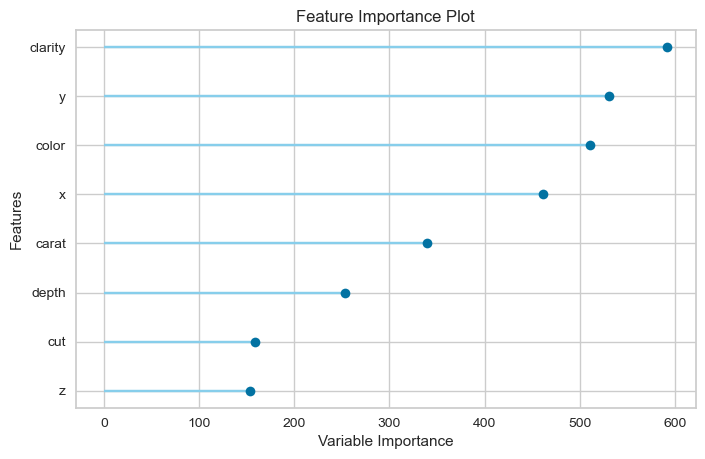

In [57]:
plot_model(lgbm_reg, plot="feature")

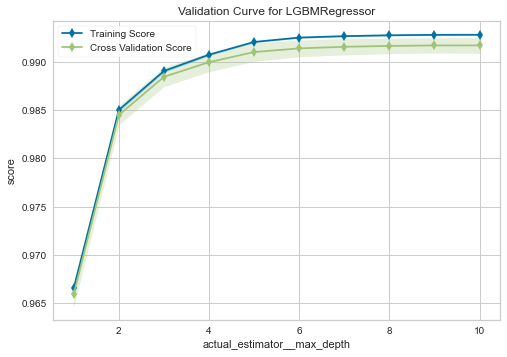

In [58]:
plot_model(lgbm_reg, plot="vc")

In [59]:
predict_model(lgbm_reg);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0665,0.0087,0.0931,0.9916,0.0106,0.0086


In [60]:
final_lgbm = finalize_model(lgbm_reg)

In [61]:
final_lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [62]:
predict_model(final_lgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0637,0.0078,0.0881,0.9925,0.0101,0.0082


In [68]:
y_pred_test_py = final_lgbm.predict(X_test)

In [70]:
mse_test_py = mse(y_test, y_pred_test_lr)

In [71]:
mse_test_py

0.03440628945958964

In [85]:
final_df["Pycaret_LGBM"] = y_pred_test_py
final_df = final_df.reset_index().drop("index", axis=1).head()

# Conclusion

In [88]:
final_df.head()

,Real,Linear_Regression,RFHyperopt,Pycaret_LGBM
0,7.625,7.578904,7.725441,7.667216
1,8.284,8.222004,8.283101,8.256391
2,8.401,8.119892,8.338785,8.354107
3,8.150,8.099549,8.047047,8.031507
4,6.170,6.340317,6.315764,6.327992


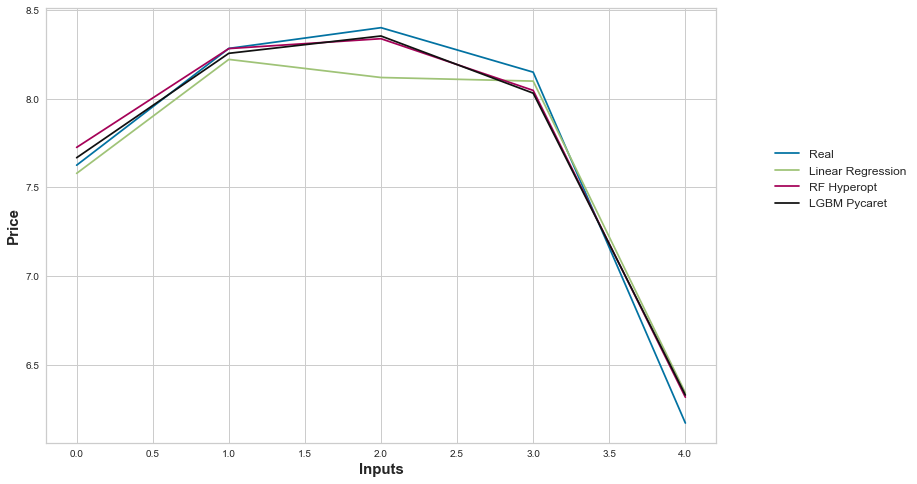

In [116]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

plt.plot(final_df.index, final_df["Real"], label = "Real", color = "b")
plt.plot(final_df.index, final_df["Linear_Regression"], label = "Linear Regression", color = "g")
plt.plot(final_df.index, final_df["RFHyperopt"], label = "RF Hyperopt", color = "m")
plt.plot(final_df.index, final_df["Pycaret_LGBM"], label = "LGBM Pycaret", color = "k")

plt.xlabel("Inputs", fontsize = 15, fontweight = "bold")
plt.ylabel("Price", fontsize = 15, fontweight = "bold")

plt.legend(loc="best", bbox_to_anchor=(1.0, 0.2, 0.3, 0.5), fontsize = 12, shadow=True)
plt.show();